In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [14]:
class Robot:
    def __init__(self,pos:np.ndarray,antennas:list):
        self.antennas = antennas
        self.position = pos
        self.num_of_antennas = len(antennas)
    def update_pos(self,pos):
        self.position = pos

In [15]:
class Tag:
    def __init__(self,pos:np.ndarray):
        self.position = pos

In [16]:
class Antenna:
    def __init__(self,z:float,G_dBm:float,theta_vector:np.ndarray,phi_vector:np.ndarray):
        self.z = z
        self.G_dBm = G_dBm
        self.theta_vector = theta_vector
        self.phi_vector = phi_vector
    
    def get_gain(self,theta_rad:float,phi_rad:float):
        theta_deg: int = round(theta_rad*180/np.pi)%360 #we don't really need the modulo here, i think but just to be safe
        phi_deg: int = round(phi_rad * 180/np.pi)%360
        return self.theta_vector[theta_deg] + self.phi_vector[phi_deg] + self.G_dBm


In [ ]:
#We assume the RFID tag frequency is 866MHz
freq = 866e6
c = 299792458.0
lambda_signal = c/freq

Pt_dBm = 30
G_R_dBm = 1

pattern = pd.read_excel("pattern.xlsx")
gain_theta = pattern["Gain_t(dB)"].to_numpy()
gain_phi = pattern["Gain_p(dB)"].to_numpy()
Antenna1 = Antenna(0.2,4,gain_theta,gain_phi)
#Antenna2 = Antenna(0.4,4,gain_theta,gain_phi)
p1 = np.array([0,0,0])
p2 = np.array([4,0,0])
Robot_inst = Robot(p1,[Antenna1])
kappa = 0.1
p3 = (1-kappa)*p1+kappa*p2


data_list = []
max_linepoints = 500 #normal value is about 2500
x_tag = 2
z_tag = 0.1
y_steps = np.linspace(0.1,3,1000) #the last number is the number of samples each epoch
for y_tag in y_steps:
    tagp = np.array([x_tag,y_tag,z_tag])
    tag1 = Tag(tagp)
    for antenna_num,antenna in enumerate(Robot_inst.antennas):
        phases = []
        orbit_power = []
        robot_pos = []
        rho = 0   
        mu,sigma = 0.0038,0.001834
        while(rho<4):
            #kappa = i/float(max_linepoints)
            #there will be a problem with z if p1 and p2 do not have z = 0
            rho = rho + np.random.normal(mu,sigma)
            new_pos = p1 + rho*(p2-p1)/np.linalg.norm(p2-p1)
            robot_pos.append(new_pos)
            Robot_inst.update_pos(new_pos)
            r = np.linalg.norm(tag1.position-Robot_inst.position)
            #we calculate the Friis equation
            if(tag1.position[0] == 0):
                theta_tag = np.pi/2
            else:
                theta_tag = np.atan(tag1.position[1]/tag1.position[0])
            theta_tag = (theta_tag + 2*np.pi)%np.pi
            if(tag1.position[2] == antenna.z):
                phi_tag = 0
            else:
                phi_tag = np.atan(np.sqrt(pow(tag1.position[0],2)+pow(tag1.position[1],2))/(tag1.position[2]-antenna.z))
            phi_tag = (phi_tag + 2*np.pi)%np.pi
            Pr = antenna.get_gain(theta_tag,phi_tag) + G_R_dBm + Pt_dBm + 20*np.log10(lambda_signal/(4*np.pi*r))
            orbit_power.append(Pr+np.random.normal(1,0.1))          #Maybe use uniformfilter1d to find the characteristics of the real noise
            phases.append( ((2*np.pi)/lambda_signal)*2*r + np.random.normal(1,0.1))
        data_list.append({
            "x_tag": x_tag,
            "y_tag": y_tag,
            "z_tag": z_tag,
            "Antenna": antenna_num,
            "robot_pos" : np.array(robot_pos),
            "Phases": np.array(phases),  # Store as list
            "Powers": np.array(orbit_power)  # Store as list
        })
    # fig = plt.figure()
    # plt.scatter(np.array([p1[0],p3[0],p2[0],tagp[0]]),np.array([p1[1],p3[1],p2[1],tagp[1]]))
    # plt.show()

    # x = np.arange(0,len(orbit_power))
    # plt.scatter(x,orbit_power)
    # plt.show()

    # fig = plt.figure()
    # x = np.arange(0,len(phases))
    # plt.scatter(x,phases)
    # plt.show()

    # fig = plt.figure()
    # x = np.arange(0,len(phases))
    # plt.scatter(x,np.array(phases)%(2*np.pi),linewidths=0.2)
    # plt.show()

    # fig = plt.figure()
    # plt.plot(gain_theta)
    # plt.plot(gain_phi)
    # plt.show()

# Convert the list to a DataFrame
df = pd.DataFrame(data_list)

# Save to an Excel file
df.to_pickle("Sim_Data_noisy.pkl")





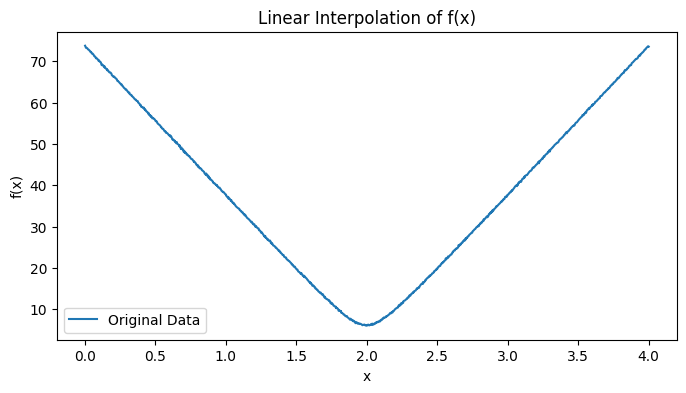

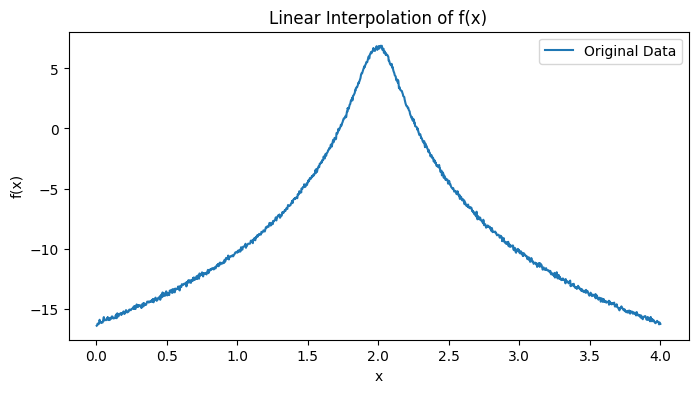

KeyboardInterrupt: 

In [42]:
Data = pd.read_pickle("Sim_Data_noisy.pkl")
#y = np.transpose(np.vstack((Data["x_tag"].to_numpy(),Data["y_tag"].to_numpy(),Data["z_tag"].to_numpy())))
y = Data["y_tag"].to_numpy()
phases = Data["Phases"].to_numpy()
powers = Data["Powers"].to_numpy()
original_pos = Data["robot_pos"]
spacing = 0.004
num_of_ys = len(phases)
for i in range(0,num_of_ys):
    phase = phases[i]
    power = powers[i]
    org_pos = original_pos[i]
    org_x = org_pos[:,0]

    x_new = np.arange(org_x[0],org_x[-1],spacing)
    linear_interp_phase = interp1d(org_x,phase,kind='linear',fill_value='extrapolate')
    linear_interp_power = interp1d(org_x,power,kind='linear',fill_value='extrapolate')
    phase_new = linear_interp_phase(x_new)
    power_new = linear_interp_power(x_new)
    plt.figure(figsize=(8, 4))
    plt.plot(org_x, phase, '-', label='Original Data')
    #plt.plot(x_new, phase_new, '-', label='Interpolated Data')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('Linear Interpolation of f(x)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(org_x, power, '-', label='Original Data')
    #plt.plot(x_new, power_new, '-', label='Interpolated Data')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('Linear Interpolation of f(x)')
    plt.legend()
    plt.show()
    
# phases = np.vstack(Data["Phases"].to_numpy())
# powers = np.vstack(Data["Powers"].to_numpy())
# original_pos = Data["robot_pos"]
# print(original_pos)
# spacing = 0.004
# linear_interp = interp1d()

